In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 

# Combination Ratio 

 > "The efficacy of each combination relative to its respective single agents was quantified with combination ratio (CR) values, defined as the IC50 or area under the fitted dose–response curve for the combination divided by the lowest IC50 or
area under the curve (AUC) value for either single agent. By this metric, a CR value of less than 1 indicates the drug combination is more effective than either single agent. We derived these CR values because of known limitations of applying conventional synergy calculations when one or more of the single agents is completely ineffective on particular samples (25)." [1]

1. Kurtz SE, Eide CA, Kaempf A, Khanna V, Savage SL, Rofelty A, et al. Molecularly targeted drug combinations demonstrate selective effectiveness for myeloid- and lymphoid-derived hematologic malignancies. Proc Natl Acad Sci U S A. 2017 Sep 5;114(36):E7554–63. 

25. Chou TC (2006) Theoretical basis, experimental design, and computerized simulation of synergism and antagonism in drug combination studies. Pharmacol Rev 58: 621–681.

--- 

We will interpret this as the following: 

$$  CR = \frac{AUC_{combination}}{min(AUC_{drug1}, AUC_{drug2})} $$ 

# Load data 

In [99]:
data = pd.read_csv('../output/HNSCC_cleaned_data.csv')
data.head()
#print( '\n'.join( data.inhibitor.unique() ) )

,lab_id,inhibitor,AUC,plate_loc,flagged,max_conc,call,replicates
0,10004,JQ1;BEZ235,1.044426,1.0:1.0:A:1.0-7.0,False,10;10,int,1.0
1,10021,JQ1;BEZ235,0.972533,2.0:1.0:A:1.0-7.0,False,10;10,int,1.0
2,10054,JQ1;BEZ235,1.639727,3.0:1.0:A:1.0-7.0,False,10;10,res,1.0
3,10058,JQ1;BEZ235,1.573965,4.0:1.0:A:1.0-7.0,False,10;10,res,1.0
4,10139,JQ1;BEZ235,1.330817,5.0:1.0:A:1.0-7.0,False,10;10,int,1.0


# Process combination 

In [100]:
def get_combination_ratio(comb, lab_id, df, verbose=True): 
    '''
    summ 
    
    input
        comb <str> should be in form: "drug1;drug2"; There should not be more than 2 drugs in combination. 
        data <dataframe> 
        
    output 
        combination ratio <float> 
    '''
    
    data = df[df.lab_id == lab_id]
    
    assert comb.count(';') == 1, f'expected only 2 drugs, received {comb.count(";")}: \n\t {comb}'
    
    drug1, drug2 = comb.strip().split(';')
    
    if verbose: print('calculating CR for:', (drug1, drug2))
        
    comb_df = data[data.inhibitor == comb]
    drug1_df = data[data.inhibitor == drug1]
    drug2_df = data[data.inhibitor == drug2]
    
    #print(comb_df)
    #print(drug1_df)
    #print(drug2_df)
    
    assert comb_df.shape[0] == 1, f'combination data expected one entry, but got {comb_df.shape[0]}'
    assert drug1_df.shape[0] == 1, f'{drug1} data expected one entry, but got {drug1_df.shape[0]}'
    assert drug2_df.shape[0] == 1, f'{drug2} data expected one entry, but got {drug2_df.shape[0]}'
    
    comb_AUC = float( comb_df['AUC'].values[0] )
    drug1_AUC = float( drug1_df['AUC'].values[0] )
    drug2_AUC = float( drug2_df['AUC'].values[0] )
    
    CR = comb_AUC / min(drug1_AUC, drug2_AUC)
    
    return CR 

# Test example

In [101]:
comb = "Vandetanib;GDC-0941"
labid = 10004

CR = get_combination_ratio(comb, labid, data)

print(f'{comb} CR value: {CR}')

calculating CR for: ('Vandetanib', 'GDC-0941')
Vandetanib;GDC-0941 CR value: 1.1173498779392539


# Process all

In [102]:
combinations = data.inhibitor.str.contains(';')

res = {'lab_id':[], 'inhibitor':[], 'CR':[]}

npat = data.lab_id.unique().shape[0]
failed_combinations = [] 

for i, labid in enumerate( data.lab_id.unique() ): 
    print(f'in progress... {i/npat * 100 :.2f}%', end='\t\t\t\r')
    pat = data[data.lab_id == labid]
    for comb in pat[pat.inhibitor.str.contains(';')].inhibitor.unique(): 
        try: 
            CR = get_combination_ratio(comb, labid, pat, verbose=False)
            res['lab_id'].append(labid)
            res['inhibitor'].append(comb)
            res['CR'].append(CR)
        except AssertionError: 
            failed_combinations.append(comb)
        
res = pd.DataFrame(res)
res.head()

,lab_id,inhibitor,CR
0,10004,Vandetanib;GDC-0941,1.117350
1,10004,Canertinib (CI-1033);PI-103,0.400734
2,10004,Vandetanib;PI-103,0.983893
3,10004,Vandetanib;Belinostat,0.704335
4,10004,Vandetanib;Idelasib (GS-1101),0.729440


# Distribution of Combination Ratio values 

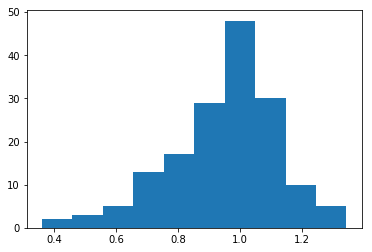

In [103]:
plt.figure()
plt.hist(res.CR)
plt.show()

# Synergistic combinations 

We'll use less than `0.9` to denote synergy 

In [67]:
syn = res[res.CR <= 0.9]
syn.head()

,lab_id,inhibitor,CR
1,10004,Canertinib (CI-1033);PI-103,0.400734
3,10004,Vandetanib;Belinostat,0.704335
4,10004,Vandetanib;Idelasib (GS-1101),0.729440
7,10004,Vandetanib;Taselisib (GDC-0032),0.752586
10,10021,Canertinib (CI-1033);PI-103,0.651554


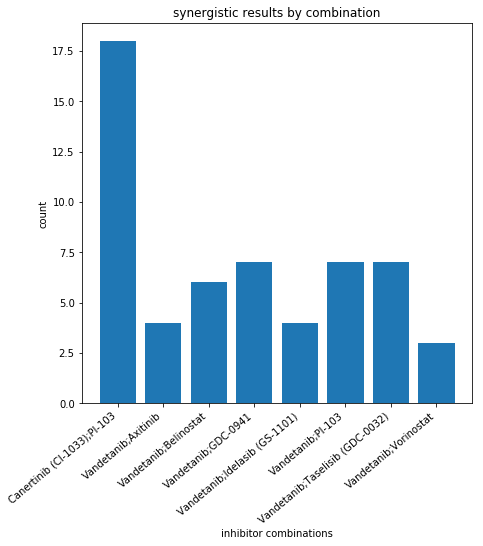

In [106]:
cnt = syn.groupby('inhibitor').count()['CR'].reset_index()

f,ax = plt.subplots(1,1, figsize=(7,7))
ax.bar(cnt.inhibitor, cnt.CR)
ax.set_xticklabels(cnt.inhibitor, rotation=40, ha='right')

ax.set_ylabel('count')
ax.set_xlabel('inhibitor combinations')
ax.set_title('synergistic results by combination')
plt.show()

# Plot CR distributions

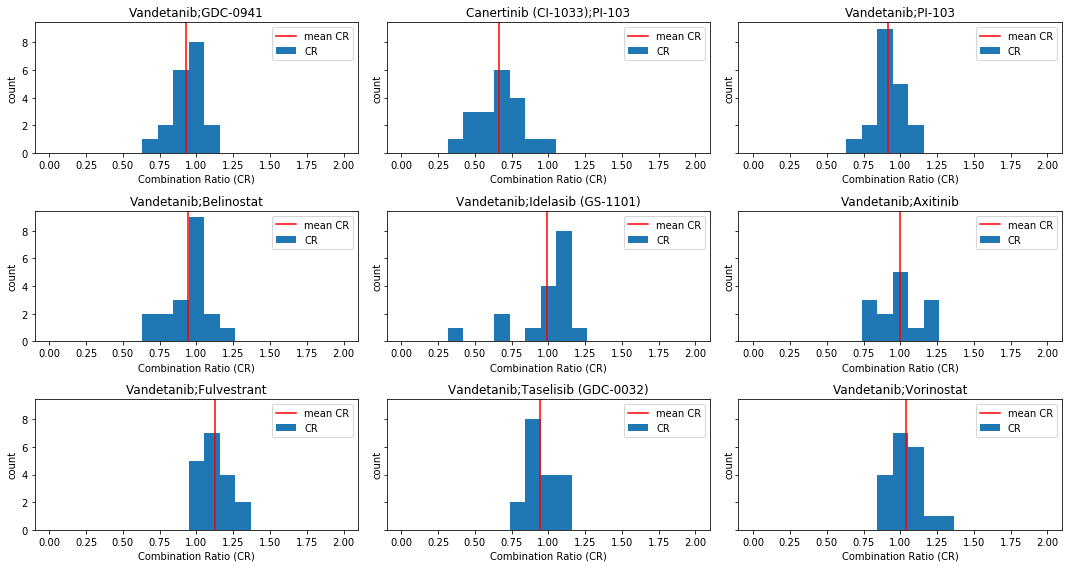

In [109]:
f,axes = plt.subplots(3,3, figsize=(15,8), sharex=False, sharey=True)

for ax, comb in zip(axes.flat, res.inhibitor.unique()): 
    df = res[res.inhibitor == comb] 
    ax.hist(df.CR, bins=np.linspace(0,2,20))
    ax.axvline(df.CR.mean(), c='r', label='mean CR')
    ax.set_title(comb)
    ax.legend()
    ax.set_xlabel('Combination Ratio (CR)')
    ax.set_ylabel('count')
    
plt.tight_layout()
plt.show()    

# Combinations that failed

I suspect most of these failed because the names aren't correct. For instance, if the single agent name is different from it's combination name, it'll fail. 

There are a number of drugs that I misinterpreted as multiple drugs, for those, it should be an easy fix. 

In [112]:
set( failed_combinations )

{'Afatinib;Gefitinib',
 'Axitinib;Gefitinib',
 'Bosutinib;Gefitinib',
 'Ceritinib;Gefitinib',
 'Crizotinib;Gefitinib',
 'Dasatinib;Erlotinib;Hydrochloride',
 'Dasatinib;Gefitinib',
 'Dasatinib;Lapatinib;Ditosylate',
 'Erlotinib;Hydrochloride;Afatinib;Dimaleate',
 'Erlotinib;Hydrochloride;Axitinib',
 'Erlotinib;Hydrochloride;BEZ235',
 'Erlotinib;Hydrochloride;Belinostat',
 'Erlotinib;Hydrochloride;Bosutinib',
 'Erlotinib;Hydrochloride;Crizotinib',
 'Erlotinib;Hydrochloride;Fulvestrant',
 'Erlotinib;Hydrochloride;GDC-0941',
 'Erlotinib;Hydrochloride;Idelasib (GS-1101)',
 'Erlotinib;Hydrochloride;Imatinib;Mesylate',
 'Erlotinib;Hydrochloride;Nilotinib',
 'Erlotinib;Hydrochloride;PI-103',
 'Erlotinib;Hydrochloride;Panobinostat',
 'Erlotinib;Hydrochloride;Pazopanib;Hydrochloride',
 'Erlotinib;Hydrochloride;Pemetrexed Disodium',
 'Erlotinib;Hydrochloride;Ponatinib;Hydrochloride',
 'Erlotinib;Hydrochloride;Romidepsin',
 'Erlotinib;Hydrochloride;Ruxolitinib;Phosphate',
 'Erlotinib;Hydrochlorid